# 📊 Model Evaluation for HR Attrition Prediction
## Comprehensive Performance Assessment & Model Comparison

**Purpose**: Evaluate and compare multiple ML models for HR attrition prediction  
**Author**: HR Analytics Team  
**Date**: September 2025  
**Version**: 2.0  

### 🎯 Objectives:
- 🔍 **Evaluate Model Performance** - Assess accuracy, precision, recall, F1-score, ROC-AUC
- 📈 **Compare Multiple Models** - Random Forest, XGBoost, Logistic Regression, SVM
- 📊 **Generate Performance Reports** - Detailed metrics, confusion matrices, ROC curves
- 🔄 **Cross-Validation Analysis** - Robust performance assessment across folds
- 📋 **Business Impact Assessment** - Translate metrics into actionable business insights
- 💾 **Model Selection** - Identify best performing model for deployment

### 📋 Notebook Structure:
1. **Setup & Data Loading** - Import libraries and load engineered features
2. **Model Training Pipeline** - Train multiple ML models with optimized parameters
3. **Performance Metrics** - Calculate comprehensive evaluation metrics
4. **Model Comparison** - Compare models across different performance dimensions
5. **Cross-Validation Analysis** - Assess model stability and generalization
6. **Visualization Dashboard** - Generate charts and performance plots
7. **Business Impact Analysis** - Translate technical metrics to business value
8. **Model Selection & Export** - Choose best model and save artifacts

### ⚡ Memory Optimization:
- Efficient model training with reduced parameters for 4GB RAM
- Strategic sampling for computationally intensive operations
- Memory cleanup after heavy model operations
- Optimized visualization generation

### 🚨 Important Notes:
- Focus on business-relevant metrics (precision/recall balance)
- Consider class imbalance in evaluation metrics
- Emphasize interpretability alongside performance
- Validate results across multiple evaluation approaches

### 📊 Expected Outputs:
- **Performance Reports**: Detailed metric comparisons
- **Visualization Dashboard**: ROC curves, confusion matrices, feature importance
- **Business Insights**: Actionable recommendations based on model performance
- **Model Artifacts**: Best model saved for deployment


In [1]:
# Import necessary libraries for model evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
from pathlib import Path
import sys
from datetime import datetime
import json
import pickle
from collections import defaultdict

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    average_precision_score, matthews_corrcoef, cohen_kappa_score
)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not available - will use RandomForest as alternative")

# Memory and performance optimization
pd.set_option('display.max_columns', 20)
warnings.filterwarnings('ignore')
np.random.seed(42)

# Project root setup
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.append(str(project_root))

# Import project modules
try:
    from src.ml_pipeline.model_evaluator import ModelEvaluator, EvaluationRunner
    print("✅ Successfully imported project modules")
    PROJECT_MODULES_AVAILABLE = True
except ImportError as e:
    print(f"⚠️ Import warning: {e}")
    print("📝 Note: Using fallback implementations")
    PROJECT_MODULES_AVAILABLE = False

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

print("🚀 Model Evaluation Setup Completed!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")

# Memory check
try:
    import psutil
    memory_info = psutil.virtual_memory()
    available_gb = memory_info.available / 1024**3
    print(f"💾 Available memory: {available_gb:.1f} GB")
    
    if available_gb < 2.0:
        print("⚠️ Low memory detected - using optimized parameters")
        MEMORY_LIMITED = True
        MAX_SAMPLES = 800
    else:
        MEMORY_LIMITED = False
        MAX_SAMPLES = 1500
except:
    MEMORY_LIMITED = True
    MAX_SAMPLES = 800
    print("⚠️ Memory check failed - assuming memory limitations")

print(f"🔢 Maximum samples for analysis: {MAX_SAMPLES}")


✅ Successfully imported project modules
🚀 Model Evaluation Setup Completed!
📊 Pandas version: 2.3.2
📈 Matplotlib version: 3.10.6
💾 Available memory: 0.4 GB
⚠️ Low memory detected - using optimized parameters
🔢 Maximum samples for analysis: 800


In [2]:
# Load engineered features and prepare for model evaluation
print("📂 Loading data for model evaluation...\n")

try:
    # Try to load engineered features first
    engineered_path = project_root / "data" / "processed" / "engineered_features.csv"
    
    if engineered_path.exists():
        print("📊 Loading engineered features...")
        df = pd.read_csv(engineered_path)
        print(f"✅ Loaded engineered features: {df.shape}")
        
    else:
        print("🔄 Engineered features not found, creating comprehensive dataset...")
        
        # Generate comprehensive synthetic dataset for evaluation
        np.random.seed(42)
        n_samples = min(MAX_SAMPLES, 1000)
        
        # Base employee data
        df = pd.DataFrame({
            'EmployeeID': [f'EMP{i:04d}' for i in range(1, n_samples + 1)],
            'Age': np.random.randint(22, 65, n_samples),
            'Department': np.random.choice(['Engineering', 'Sales', 'HR', 'Marketing', 'Finance', 'Operations'], n_samples),
            'JobRole': np.random.choice(['Manager', 'Senior', 'Junior', 'Lead', 'Associate'], n_samples),
            'MonthlyIncome': np.random.normal(7500, 2500, n_samples).astype(int),
            'YearsAtCompany': np.random.gamma(2, 2, n_samples).astype(int),
            'YearsInCurrentRole': np.random.gamma(1.5, 1.5, n_samples).astype(int),
            'YearsSinceLastPromotion': np.random.gamma(1, 2, n_samples).astype(int),
            'PerformanceRating': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.05, 0.10, 0.50, 0.30, 0.05]),
            'JobSatisfaction': np.random.randint(1, 5, n_samples),
            'WorkLifeBalance': np.random.randint(1, 5, n_samples),
            'EnvironmentSatisfaction': np.random.randint(1, 5, n_samples),
            'OverTime': np.random.choice(['Yes', 'No'], n_samples, p=[0.28, 0.72]),
            'Gender': np.random.choice(['Male', 'Female'], n_samples),
            'MaritalStatus': np.random.choice(['Single', 'Married', 'Divorced'], n_samples, p=[0.35, 0.55, 0.10]),
            'DistanceFromHome': np.random.randint(1, 30, n_samples),
            'TotalWorkingYears': np.random.randint(1, 40, n_samples),
            'Education': np.random.choice(['Below College', 'College', 'Bachelor', 'Master', 'Doctor'], n_samples, p=[0.10, 0.15, 0.45, 0.25, 0.05]),
            'EducationField': np.random.choice(['Technical', 'Medical', 'Marketing', 'Other'], n_samples)
        })
        
        # Create realistic attrition patterns
        attrition_prob = (
            0.05 +  # Base rate
            0.20 * (df['OverTime'] == 'Yes') +
            0.15 * (df['JobSatisfaction'] <= 2) +
            0.10 * (df['WorkLifeBalance'] <= 2) +
            0.08 * (df['PerformanceRating'] <= 2) +
            0.05 * (df['DistanceFromHome'] > 20) +
            0.03 * (df['YearsSinceLastPromotion'] > 5)
        ).clip(0, 0.8)
        
        df['Attrition'] = np.random.binomial(1, attrition_prob, n_samples)
        df['Attrition'] = df['Attrition'].map({1: 'Yes', 0: 'No'})
        
        # Add engineered features
        df['Income_to_Age_Ratio'] = df['MonthlyIncome'] / df['Age']
        df['Tenure_to_Age_Ratio'] = df['YearsAtCompany'] / df['Age']
        df['Role_Tenure_Ratio'] = df['YearsInCurrentRole'] / (df['YearsAtCompany'] + 1)
        df['Satisfaction_Score'] = (df['JobSatisfaction'] + df['WorkLifeBalance'] + df['EnvironmentSatisfaction']) / 3
        df['High_Overtime_Risk'] = (df['OverTime'] == 'Yes').astype(int)
        df['Low_Satisfaction_Risk'] = (df['JobSatisfaction'] <= 2).astype(int)
        df['High_Distance_Risk'] = (df['DistanceFromHome'] > 15).astype(int)
        df['Performance_Risk'] = (df['PerformanceRating'] <= 2).astype(int)
        
        print(f"✅ Generated comprehensive synthetic dataset: {df.shape}")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# Dataset overview
print(f"\n📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Target distribution
target_dist = df['Attrition'].value_counts(normalize=True)
print(f"\n🎯 Target Distribution:")
for category, percentage in target_dist.items():
    print(f"   {category}: {(df['Attrition'] == category).sum()} ({percentage:.1%})")

# Feature types analysis
categorical_cols = []
numerical_cols = []

for col in df.columns:
    if col in ['EmployeeID', 'Attrition']:
        continue
    elif df[col].dtype == 'object' or df[col].nunique() < 10:
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

print(f"\n📈 Feature Analysis:")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")

# Handle preprocessing
print(f"\n🔧 Preprocessing data...")

# Create a copy for preprocessing
df_processed = df.copy()

# Label encoding for categorical variables
label_encoders = {}
for col in categorical_cols:
    if col != 'Attrition':  # Don't encode target
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"✅ Encoded {col}: {len(le.classes_)} categories")

# Prepare features and target
feature_cols = [col for col in df_processed.columns if col not in ['EmployeeID', 'Attrition']]
X = df_processed[feature_cols]
y = (df_processed['Attrition'] == 'Yes').astype(int)

# Handle missing values
if X.isnull().sum().sum() > 0:
    print("⚠️ Handling missing values...")
    for col in X.columns:
        if X[col].dtype in ['int64', 'float64']:
            X[col] = X[col].fillna(X[col].median())
        else:
            X[col] = X[col].fillna(X[col].mode()[0])

print(f"\n📊 Final dataset for modeling:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Attrition rate: {y.mean():.1%}")

# Sample data for memory efficiency if needed
if len(X) > MAX_SAMPLES:
    print(f"🔄 Sampling {MAX_SAMPLES} records for memory efficiency...")
    sample_indices = np.random.choice(len(X), MAX_SAMPLES, replace=False)
    X = X.iloc[sample_indices].reset_index(drop=True)
    y = y.iloc[sample_indices].reset_index(drop=True)
    print(f"✅ Sampled dataset: {X.shape}")

# Display sample
print(f"\n🔍 Sample of features:")
display(X.head())

# Memory cleanup
gc.collect()


📂 Loading data for model evaluation...

📊 Loading engineered features...
✅ Loaded engineered features: (800, 43)

📊 Dataset Overview:
Shape: (800, 43)
Memory usage: 0.9 MB

🎯 Target Distribution:
   No: 673 (84.1%)
   Yes: 127 (15.9%)

📈 Feature Analysis:
Categorical features (27): ['Department', 'JobRole', 'PerformanceRating', 'JobSatisfaction', 'WorkLifeBalance', 'EnvironmentSatisfaction', 'OverTime', 'Gender', 'MaritalStatus', 'Satisfaction_Score', 'Income_Quartile', 'Age_Group', 'Tenure_Group', 'Performance_Category', 'Distance_Category', 'Satisfaction_Level', 'High_Overtime_Risk', 'Low_Satisfaction_Risk', 'High_Distance_Risk', 'Stagnation_Risk', 'Dept_Role_Combo', 'Age_Income_Segment', 'Performance_Satisfaction', 'WorkLife_Combined_Score', 'Senior_High_Performer', 'Composite_Risk_Score', 'Risk_Level']
Numerical features (14): ['Age', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'DistanceFromHome', 'TotalWorkingYears', 'Income_to_Age_Ratio', '

,Age,Department,JobRole,MonthlyIncome,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,PerformanceRating,JobSatisfaction,WorkLifeBalance,...,Low_Satisfaction_Risk,High_Distance_Risk,Stagnation_Risk,Dept_Role_Combo,Age_Income_Segment,Performance_Satisfaction,WorkLife_Combined_Score,Senior_High_Performer,Composite_Risk_Score,Risk_Level
0,60,1,2,7650,2,5,0,3,3,2,...,0,1,0,6,12,2,1,0,2,2
1,50,3,3,3472,1,0,0,3,1,1,...,1,1,0,15,9,1,0,0,3,0
2,36,4,1,6123,0,0,4,1,3,2,...,0,0,0,17,6,8,2,0,0,1
3,64,3,2,9532,1,3,2,1,2,2,...,0,0,0,14,15,8,3,0,0,1
4,29,4,1,8622,5,4,2,1,3,0,...,0,0,0,17,0,7,1,0,0,1


40

In [3]:
# Split data and set up models for evaluation
print("🔄 Setting up train-test split and model configurations...\n")

# Strategic train-test split
test_size = 0.25 if len(X) > 400 else 0.3  # Adjust based on sample size
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print(f"📊 Data Split:")
print(f"Training set: {X_train.shape} - Attrition rate: {y_train.mean():.1%}")
print(f"Test set: {X_test.shape} - Attrition rate: {y_test.mean():.1%}")

# Model configurations optimized for 4GB RAM and performance
models_config = {}

# 1. Random Forest (Primary choice - good performance/interpretability balance)
models_config['Random Forest'] = {
    'model': RandomForestClassifier(
        n_estimators=50 if MEMORY_LIMITED else 100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=1 if MEMORY_LIMITED else -1
    ),
    'description': 'Tree-based ensemble with high interpretability',
    'strengths': ['Feature importance', 'Handles mixed data types', 'Robust to outliers'],
    'use_case': 'Primary model for production due to interpretability'
}

# 2. XGBoost (if available) or Extra Trees (fallback)
if XGBOOST_AVAILABLE:
    models_config['XGBoost'] = {
        'model': xgb.XGBClassifier(
            n_estimators=50 if MEMORY_LIMITED else 100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
            random_state=42,
            n_jobs=1 if MEMORY_LIMITED else -1,
            eval_metric='logloss'
        ),
        'description': 'Gradient boosting with advanced regularization',
        'strengths': ['High performance', 'Built-in regularization', 'Handle missing values'],
        'use_case': 'Performance benchmark and ensemble component'
    }
else:
    from sklearn.ensemble import ExtraTreesClassifier
    models_config['Extra Trees'] = {
        'model': ExtraTreesClassifier(
            n_estimators=50 if MEMORY_LIMITED else 100,
            max_depth=10,
            min_samples_split=5,
            class_weight='balanced',
            random_state=42,
            n_jobs=1 if MEMORY_LIMITED else -1
        ),
        'description': 'Extremely randomized trees for reduced overfitting',
        'strengths': ['Fast training', 'Reduced variance', 'Good generalization'],
        'use_case': 'Alternative to XGBoost with similar interpretability'
    }

# 3. Logistic Regression (Baseline interpretable model)
models_config['Logistic Regression'] = {
    'model': LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        solver='liblinear'
    ),
    'description': 'Linear model with probabilistic output',
    'strengths': ['Highly interpretable', 'Fast training', 'Probabilistic output'],
    'use_case': 'Baseline model and coefficient interpretation'
}

# 4. Support Vector Machine (Non-linear patterns)
models_config['SVM'] = {
    'model': SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=42,
        gamma='scale',
        C=1.0
    ),
    'description': 'Support Vector Machine with RBF kernel',
    'strengths': ['Handle non-linear patterns', 'Robust to overfitting', 'Memory efficient'],
    'use_case': 'Capture complex feature interactions'
}

# 5. Naive Bayes (Fast baseline)
models_config['Naive Bayes'] = {
    'model': GaussianNB(),
    'description': 'Probabilistic classifier assuming feature independence',
    'strengths': ['Very fast', 'Works with small datasets', 'No hyperparameter tuning'],
    'use_case': 'Quick baseline and probability calibration reference'
}

# 6. K-Nearest Neighbors (Instance-based learning)
models_config['KNN'] = {
    'model': KNeighborsClassifier(
        n_neighbors=min(7, len(X_train) // 10),  # Adaptive to dataset size
        weights='distance',
        metric='euclidean'
    ),
    'description': 'Instance-based learning with distance weighting',
    'strengths': ['No assumptions about data', 'Captures local patterns', 'Intuitive'],
    'use_case': 'Detect local patterns and similarity-based predictions'
}

print(f"🤖 Configured {len(models_config)} models:")
for name, config in models_config.items():
    print(f"   • {name}: {config['description']}")

# Initialize results storage
model_results = {}
trained_models = {}
training_times = {}

print(f"\n📚 Model details:")
for name, config in models_config.items():
    print(f"\n🔹 {name}:")
    print(f"   Description: {config['description']}")
    print(f"   Strengths: {', '.join(config['strengths'])}")
    print(f"   Use case: {config['use_case']}")

# Memory status check
gc.collect()
print(f"\n💾 Memory optimizations applied: {MEMORY_LIMITED}")
print(f"📊 Ready to train {len(models_config)} models on {len(X_train)} training samples")


🔄 Setting up train-test split and model configurations...

📊 Data Split:
Training set: (600, 41) - Attrition rate: 15.8%
Test set: (200, 41) - Attrition rate: 16.0%
🤖 Configured 6 models:
   • Random Forest: Tree-based ensemble with high interpretability
   • XGBoost: Gradient boosting with advanced regularization
   • Logistic Regression: Linear model with probabilistic output
   • SVM: Support Vector Machine with RBF kernel
   • Naive Bayes: Probabilistic classifier assuming feature independence
   • KNN: Instance-based learning with distance weighting

📚 Model details:

🔹 Random Forest:
   Description: Tree-based ensemble with high interpretability
   Strengths: Feature importance, Handles mixed data types, Robust to outliers
   Use case: Primary model for production due to interpretability

🔹 XGBoost:
   Description: Gradient boosting with advanced regularization
   Strengths: High performance, Built-in regularization, Handle missing values
   Use case: Performance benchmark and en

In [4]:
# Train models and perform initial evaluation
print("🚀 Training models and performing initial evaluation...\n")

from sklearn.model_selection import cross_val_score
import time

# Feature scaling for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models that benefit from scaling
scale_sensitive_models = ['Logistic Regression', 'SVM', 'KNN']

# Train each model
for model_name, config in models_config.items():
    print(f"🔹 Training {model_name}...")
    
    try:
        # Select appropriate data (scaled or original)
        if model_name in scale_sensitive_models:
            X_train_use = X_train_scaled
            X_test_use = X_test_scaled
        else:
            X_train_use = X_train
            X_test_use = X_test
        
        # Train model
        start_time = time.time()
        model = config['model']
        model.fit(X_train_use, y_train)
        training_time = time.time() - start_time
        
        # Store trained model and timing
        trained_models[model_name] = {
            'model': model,
            'scaler': scaler if model_name in scale_sensitive_models else None,
            'training_time': training_time
        }
        training_times[model_name] = training_time
        
        # Make predictions
        y_pred = model.predict(X_test_use)
        y_pred_proba = model.predict_proba(X_test_use)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate basic metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Calculate AUC if probabilities available
        if y_pred_proba is not None:
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except ValueError:
                roc_auc = 0.5  # Random classifier performance
        else:
            roc_auc = None
        
        # Store results
        model_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'training_time': training_time,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'model_config': config
        }
        
        # Print immediate results
        print(f"   ✅ {model_name} trained in {training_time:.2f}s")
        print(f"      Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
        if roc_auc is not None:
            print(f"      ROC-AUC: {roc_auc:.3f}")
        
        # Quick cross-validation (3-fold for speed)
        try:
            cv_scores = cross_val_score(model, X_train_use, y_train, cv=3, scoring='f1', n_jobs=1)
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
            print(f"      CV F1-Score: {cv_mean:.3f} (±{cv_std:.3f})")
            model_results[model_name]['cv_f1_mean'] = cv_mean
            model_results[model_name]['cv_f1_std'] = cv_std
        except Exception as e:
            print(f"      ⚠️ CV evaluation failed: {e}")
            model_results[model_name]['cv_f1_mean'] = f1
            model_results[model_name]['cv_f1_std'] = 0.0
        
    except Exception as e:
        print(f"   ❌ Failed to train {model_name}: {e}")
        continue
    
    print()

# Training summary
print(f"📊 Training Summary:")
print(f"{'Model':<20} {'Accuracy':<10} {'F1-Score':<10} {'ROC-AUC':<10} {'Time(s)':<8}")
print("-" * 58)

for model_name, results in model_results.items():
    accuracy = results['accuracy']
    f1 = results['f1_score']
    roc_auc = results['roc_auc'] if results['roc_auc'] is not None else 0
    training_time = results['training_time']
    
    print(f"{model_name:<20} {accuracy:<10.3f} {f1:<10.3f} {roc_auc:<10.3f} {training_time:<8.2f}")

# Identify best models
best_accuracy = max(model_results.values(), key=lambda x: x['accuracy'])
best_f1 = max(model_results.values(), key=lambda x: x['f1_score'])
best_auc = max([r for r in model_results.values() if r['roc_auc'] is not None], 
              key=lambda x: x['roc_auc'], default={'roc_auc': 0})

print(f"\n🏆 Best Performers:")
for name, results in model_results.items():
    if results == best_accuracy:
        print(f"   🎯 Best Accuracy: {name} ({results['accuracy']:.3f})")
    if results == best_f1:
        print(f"   ⚖️ Best F1-Score: {name} ({results['f1_score']:.3f})")
    if results == best_auc and best_auc['roc_auc'] > 0:
        print(f"   📈 Best ROC-AUC: {name} ({results['roc_auc']:.3f})")

# Memory cleanup
gc.collect()
print(f"\n✅ Model training completed successfully!")


🚀 Training models and performing initial evaluation...

🔹 Training Random Forest...
   ✅ Random Forest trained in 0.42s
      Accuracy: 0.835 | Precision: 0.000 | Recall: 0.000 | F1: 0.000
      ROC-AUC: 0.430
      CV F1-Score: 0.000 (±0.000)

🔹 Training XGBoost...
   ✅ XGBoost trained in 0.96s
      Accuracy: 0.790 | Precision: 0.083 | Recall: 0.031 | F1: 0.045
      ROC-AUC: 0.445
      CV F1-Score: 0.091 (±0.039)

🔹 Training Logistic Regression...
   ✅ Logistic Regression trained in 0.06s
      Accuracy: 0.525 | Precision: 0.146 | Recall: 0.406 | F1: 0.215
      ROC-AUC: 0.464
      CV F1-Score: 0.261 (±0.001)

🔹 Training SVM...
   ✅ SVM trained in 1.41s
      Accuracy: 0.650 | Precision: 0.135 | Recall: 0.219 | F1: 0.167
      ROC-AUC: 0.508
      CV F1-Score: 0.164 (±0.015)

🔹 Training Naive Bayes...
   ✅ Naive Bayes trained in 0.01s
      Accuracy: 0.740 | Precision: 0.115 | Recall: 0.094 | F1: 0.103
      ROC-AUC: 0.440
      CV F1-Score: 0.228 (±0.048)

🔹 Training KNN...
   ✅ 

In [5]:
# Detailed performance analysis and metrics calculation
print("📊 Performing detailed performance analysis...\n")

from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, log_loss, brier_score_loss

# Extended metrics calculation
extended_results = {}

for model_name, basic_results in model_results.items():
    print(f"🔍 Analyzing {model_name}...")
    
    y_pred = basic_results['predictions']
    y_pred_proba = basic_results['probabilities']
    
    # Confusion matrix analysis
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    balanced_accuracy = (basic_results['recall'] + specificity) / 2
    
    # Statistical metrics
    matthews_cc = matthews_corrcoef(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    
    # Probability-based metrics (if available)
    if y_pred_proba is not None:
        try:
            logloss = log_loss(y_test, y_pred_proba)
            brier_score = brier_score_loss(y_test, y_pred_proba)
            precision_recall_auc = average_precision_score(y_test, y_pred_proba)
        except Exception as e:
            print(f"   ⚠️ Error calculating probability metrics: {e}")
            logloss = brier_score = precision_recall_auc = 0.0
    else:
        logloss = brier_score = precision_recall_auc = 0.0
    
    # Business metrics
    # Cost-benefit analysis (assuming costs)
    cost_fp = 100  # Cost of false positive (unnecessary intervention)
    cost_fn = 1000  # Cost of false negative (missed attrition)
    cost_tp = 50   # Cost of true positive (intervention cost)
    cost_tn = 0    # Cost of true negative (no action needed)
    
    total_cost = (fp * cost_fp + fn * cost_fn + tp * cost_tp + tn * cost_tn)
    cost_per_employee = total_cost / len(y_test)
    
    # Store extended results
    extended_results[model_name] = {
        **basic_results,  # Include basic results
        'confusion_matrix': cm,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'specificity': specificity,
        'npv': npv,
        'balanced_accuracy': balanced_accuracy,
        'matthews_corrcoef': matthews_cc,
        'cohen_kappa': cohen_kappa,
        'log_loss': logloss,
        'brier_score': brier_score,
        'precision_recall_auc': precision_recall_auc,
        'total_cost': total_cost,
        'cost_per_employee': cost_per_employee
    }
    
    print(f"   ✅ Extended analysis completed")

# Create comprehensive comparison DataFrame
comparison_data = []
for model_name, results in extended_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score'],
        'ROC-AUC': results['roc_auc'] if results['roc_auc'] is not None else 0,
        'Specificity': results['specificity'],
        'Balanced_Acc': results['balanced_accuracy'],
        'Matthews_CC': results['matthews_corrcoef'],
        'Cohen_Kappa': results['cohen_kappa'],
        'PR-AUC': results['precision_recall_auc'],
        'Log_Loss': results['log_loss'],
        'Training_Time': results['training_time'],
        'Cost_Per_Emp': results['cost_per_employee']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print(f"\n📋 Comprehensive Performance Comparison:")
print("=" * 100)

# Display key metrics
key_metrics = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Balanced_Acc']
print(comparison_df[key_metrics].to_string(index=False))

print(f"\n📊 Advanced Metrics:")
advanced_metrics = ['Model', 'Matthews_CC', 'Cohen_Kappa', 'PR-AUC', 'Log_Loss', 'Training_Time']
print(comparison_df[advanced_metrics].to_string(index=False))

print(f"\n💰 Business Impact Analysis:")
business_metrics = ['Model', 'Cost_Per_Emp', 'Specificity']
print(comparison_df[business_metrics].to_string(index=False))

# Model ranking analysis
print(f"\n🏆 Model Rankings by Different Metrics:")

metrics_to_rank = ['Accuracy', 'F1-Score', 'ROC-AUC', 'Balanced_Acc', 'Matthews_CC']
rankings = {}

for metric in metrics_to_rank:
    if metric in comparison_df.columns:
        ranked = comparison_df.nlargest(3, metric)[['Model', metric]]
        rankings[metric] = ranked
        print(f"\n📊 Top 3 by {metric}:")
        for idx, (_, row) in enumerate(ranked.iterrows(), 1):
            print(f"   {idx}. {row['Model']}: {row[metric]:.4f}")

# Overall performance score (weighted combination)
weights = {
    'F1-Score': 0.3,
    'ROC-AUC': 0.25,
    'Balanced_Acc': 0.2,
    'Matthews_CC': 0.15,
    'Precision': 0.1
}

comparison_df['Overall_Score'] = 0
for metric, weight in weights.items():
    if metric in comparison_df.columns:
        # Normalize to 0-1 range
        normalized = (comparison_df[metric] - comparison_df[metric].min()) / (comparison_df[metric].max() - comparison_df[metric].min())
        comparison_df['Overall_Score'] += normalized * weight

# Sort by overall score
comparison_df = comparison_df.sort_values('Overall_Score', ascending=False)

print(f"\n🎯 Overall Model Ranking (Weighted Score):")
print("=" * 50)
for idx, (_, row) in enumerate(comparison_df.iterrows(), 1):
    print(f"{idx}. {row['Model']:<20} Score: {row['Overall_Score']:.4f}")

# Store results for later use
final_results = {
    'comparison_df': comparison_df,
    'extended_results': extended_results,
    'rankings': rankings,
    'best_model': comparison_df.iloc[0]['Model']
}

print(f"\n✅ Detailed performance analysis completed!")
print(f"🏆 Best overall model: {final_results['best_model']}")

# Memory cleanup
gc.collect()


📊 Performing detailed performance analysis...

🔍 Analyzing Random Forest...
   ✅ Extended analysis completed
🔍 Analyzing XGBoost...
   ✅ Extended analysis completed
🔍 Analyzing Logistic Regression...
   ✅ Extended analysis completed
🔍 Analyzing SVM...
   ✅ Extended analysis completed
🔍 Analyzing Naive Bayes...
   ✅ Extended analysis completed
🔍 Analyzing KNN...
   ✅ Extended analysis completed

📋 Comprehensive Performance Comparison:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Balanced_Acc
      Random Forest     0.835     0.0000  0.0000    0.0000   0.4302        0.4970
            XGBoost     0.790     0.0833  0.0312    0.0455   0.4455        0.4829
Logistic Regression     0.525     0.1461  0.4062    0.2149   0.4637        0.4769
                SVM     0.650     0.1346  0.2188    0.1667   0.5076        0.4754
        Naive Bayes     0.740     0.1154  0.0938    0.1034   0.4399        0.4784
                KNN     0.830     0.0000  0.0000    0.0000   0.5126   

0

In [6]:
# Comprehensive cross-validation and model stability analysis
print("🔄 Performing cross-validation and stability analysis...\n")

from sklearn.model_selection import StratifiedKFold, cross_validate
import warnings
warnings.filterwarnings('ignore')

# Cross-validation setup
cv_folds = 5 if len(X_train) > 200 else 3  # Adjust based on sample size
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"📊 Performing {cv_folds}-fold cross-validation...")

# Metrics to evaluate
cv_scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Cross-validation results
cv_results = {}
cv_summary = []

for model_name, model_info in trained_models.items():
    print(f"\n🔹 Cross-validating {model_name}...")
    
    try:
        model = model_info['model']
        
        # Select appropriate data
        if model_name in scale_sensitive_models:
            X_cv = X_train_scaled
        else:
            X_cv = X_train
        
        # Perform cross-validation
        start_time = time.time()
        cv_scores = cross_validate(
            model, X_cv, y_train,
            cv=cv,
            scoring=cv_scoring,
            n_jobs=1,  # Conservative for memory
            return_train_score=True,
            error_score='raise'
        )
        cv_time = time.time() - start_time
        
        # Process results
        results = {}
        for metric in cv_scoring.keys():
            test_scores = cv_scores[f'test_{metric}']
            train_scores = cv_scores[f'train_{metric}']
            
            results[f'{metric}_test_mean'] = np.mean(test_scores)
            results[f'{metric}_test_std'] = np.std(test_scores)
            results[f'{metric}_train_mean'] = np.mean(train_scores)
            results[f'{metric}_train_std'] = np.std(train_scores)
            results[f'{metric}_test_scores'] = test_scores
            results[f'{metric}_train_scores'] = train_scores
            
            # Calculate overfitting indicator
            overfitting = np.mean(train_scores) - np.mean(test_scores)
            results[f'{metric}_overfitting'] = overfitting
        
        results['cv_time'] = cv_time
        results['cv_folds'] = cv_folds
        
        cv_results[model_name] = results
        
        # Print summary
        print(f"   ✅ Completed in {cv_time:.2f}s")
        print(f"      F1-Score: {results['f1_test_mean']:.3f} (±{results['f1_test_std']:.3f})")
        print(f"      ROC-AUC:  {results['roc_auc_test_mean']:.3f} (±{results['roc_auc_test_std']:.3f})")
        print(f"      Overfitting (F1): {results['f1_overfitting']:.3f}")
        
        # Store for summary
        cv_summary.append({
            'Model': model_name,
            'F1_Mean': results['f1_test_mean'],
            'F1_Std': results['f1_test_std'],
            'ROC_AUC_Mean': results['roc_auc_test_mean'],
            'ROC_AUC_Std': results['roc_auc_test_std'],
            'Accuracy_Mean': results['accuracy_test_mean'],
            'Accuracy_Std': results['accuracy_test_std'],
            'F1_Overfitting': results['f1_overfitting'],
            'ROC_Overfitting': results['roc_auc_overfitting'],
            'CV_Time': cv_time
        })
        
    except Exception as e:
        print(f"   ❌ Cross-validation failed for {model_name}: {e}")
        continue

# Create CV summary DataFrame
cv_summary_df = pd.DataFrame(cv_summary)
if not cv_summary_df.empty:
    cv_summary_df = cv_summary_df.round(4)

print(f"\n📊 Cross-Validation Summary:")
print("=" * 80)
if not cv_summary_df.empty:
    print(cv_summary_df[['Model', 'F1_Mean', 'F1_Std', 'ROC_AUC_Mean', 'ROC_AUC_Std', 'Accuracy_Mean']].to_string(index=False))
else:
    print("No cross-validation results available")

# Stability analysis
if not cv_summary_df.empty:
    print(f"\n🔍 Model Stability Analysis:")
    print("=" * 50)
    
    # Low standard deviation indicates stable performance
    most_stable_f1 = cv_summary_df.loc[cv_summary_df['F1_Std'].idxmin()]
    most_stable_auc = cv_summary_df.loc[cv_summary_df['ROC_AUC_Std'].idxmin()]
    
    print(f"🔒 Most Stable Models:")
    print(f"   F1-Score: {most_stable_f1['Model']} (std: {most_stable_f1['F1_Std']:.4f})")
    print(f"   ROC-AUC:  {most_stable_auc['Model']} (std: {most_stable_auc['ROC_AUC_Std']:.4f})")
    
    # Overfitting analysis
    print(f"\n⚖️ Overfitting Analysis:")
    overfitting_threshold = 0.05
    
    for _, row in cv_summary_df.iterrows():
        f1_overfit = row['F1_Overfitting']
        roc_overfit = row['ROC_Overfitting']
        
        if f1_overfit > overfitting_threshold or roc_overfit > overfitting_threshold:
            print(f"   ⚠️ {row['Model']}: F1 overfit={f1_overfit:.3f}, ROC overfit={roc_overfit:.3f}")
        else:
            print(f"   ✅ {row['Model']}: Well-generalized")
    
    # Confidence intervals
    print(f"\n📊 95% Confidence Intervals (F1-Score):")
    for _, row in cv_summary_df.iterrows():
        mean = row['F1_Mean']
        std = row['F1_Std']
        ci_lower = mean - 1.96 * std
        ci_upper = mean + 1.96 * std
        print(f"   {row['Model']:<20}: {mean:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]")

# Learning curve analysis for best models (top 3)
print(f"\n📈 Learning Curve Analysis for Top Models:")

if not cv_summary_df.empty:
    top_3_models = cv_summary_df.nlargest(3, 'F1_Mean')['Model'].tolist()
    
    learning_curves = {}
    
    for model_name in top_3_models[:2]:  # Analyze top 2 to save time
        if model_name in trained_models:
            print(f"\n   📊 Analyzing {model_name}...")
            
            try:
                model = trained_models[model_name]['model']
                X_lc = X_train_scaled if model_name in scale_sensitive_models else X_train
                
                # Learning curve with different training sizes
                train_sizes = np.linspace(0.1, 1.0, 5)
                
                from sklearn.model_selection import learning_curve
                train_sizes_abs, train_scores, val_scores = learning_curve(
                    model, X_lc, y_train,
                    train_sizes=train_sizes,
                    cv=3,  # Smaller CV for speed
                    scoring='f1',
                    n_jobs=1,
                    random_state=42
                )
                
                learning_curves[model_name] = {
                    'train_sizes': train_sizes_abs,
                    'train_scores': train_scores,
                    'val_scores': val_scores,
                    'train_mean': np.mean(train_scores, axis=1),
                    'train_std': np.std(train_scores, axis=1),
                    'val_mean': np.mean(val_scores, axis=1),
                    'val_std': np.std(val_scores, axis=1)
                }
                
                # Print learning curve insights
                final_gap = learning_curves[model_name]['train_mean'][-1] - learning_curves[model_name]['val_mean'][-1]
                print(f"      Learning curve completed")
                print(f"      Final train-val gap: {final_gap:.3f}")
                
            except Exception as e:
                print(f"      ⚠️ Learning curve analysis failed: {e}")

# Store CV results for later use
cv_analysis_results = {
    'cv_results': cv_results,
    'cv_summary_df': cv_summary_df,
    'learning_curves': learning_curves if 'learning_curves' in locals() else {},
    'most_stable_model': most_stable_f1['Model'] if not cv_summary_df.empty else None
}

print(f"\n✅ Cross-validation analysis completed!")
if cv_analysis_results['most_stable_model']:
    print(f"🔒 Most stable model: {cv_analysis_results['most_stable_model']}")

# Memory cleanup
gc.collect()


🔄 Performing cross-validation and stability analysis...

📊 Performing 5-fold cross-validation...

🔹 Cross-validating Random Forest...
   ✅ Completed in 3.92s
      F1-Score: 0.000 (±0.000)
      ROC-AUC:  0.523 (±0.101)
      Overfitting (F1): 0.991

🔹 Cross-validating XGBoost...
   ✅ Completed in 3.42s
      F1-Score: 0.110 (±0.052)
      ROC-AUC:  0.501 (±0.049)
      Overfitting (F1): 0.888

🔹 Cross-validating Logistic Regression...
   ✅ Completed in 0.87s
      F1-Score: 0.258 (±0.034)
      ROC-AUC:  0.522 (±0.051)
      Overfitting (F1): 0.113

🔹 Cross-validating SVM...
   ✅ Completed in 3.74s
      F1-Score: 0.203 (±0.088)
      ROC-AUC:  0.478 (±0.058)
      Overfitting (F1): 0.554

🔹 Cross-validating Naive Bayes...
   ✅ Completed in 0.45s
      F1-Score: 0.277 (±0.079)
      ROC-AUC:  0.534 (±0.081)
      Overfitting (F1): 0.064

🔹 Cross-validating KNN...
   ✅ Completed in 0.42s
      F1-Score: 0.019 (±0.038)
      ROC-AUC:  0.425 (±0.049)
      Overfitting (F1): 0.981

📊 Cros

288

📊 Creating comprehensive visualization dashboard...

📈 Creating performance comparison dashboard...


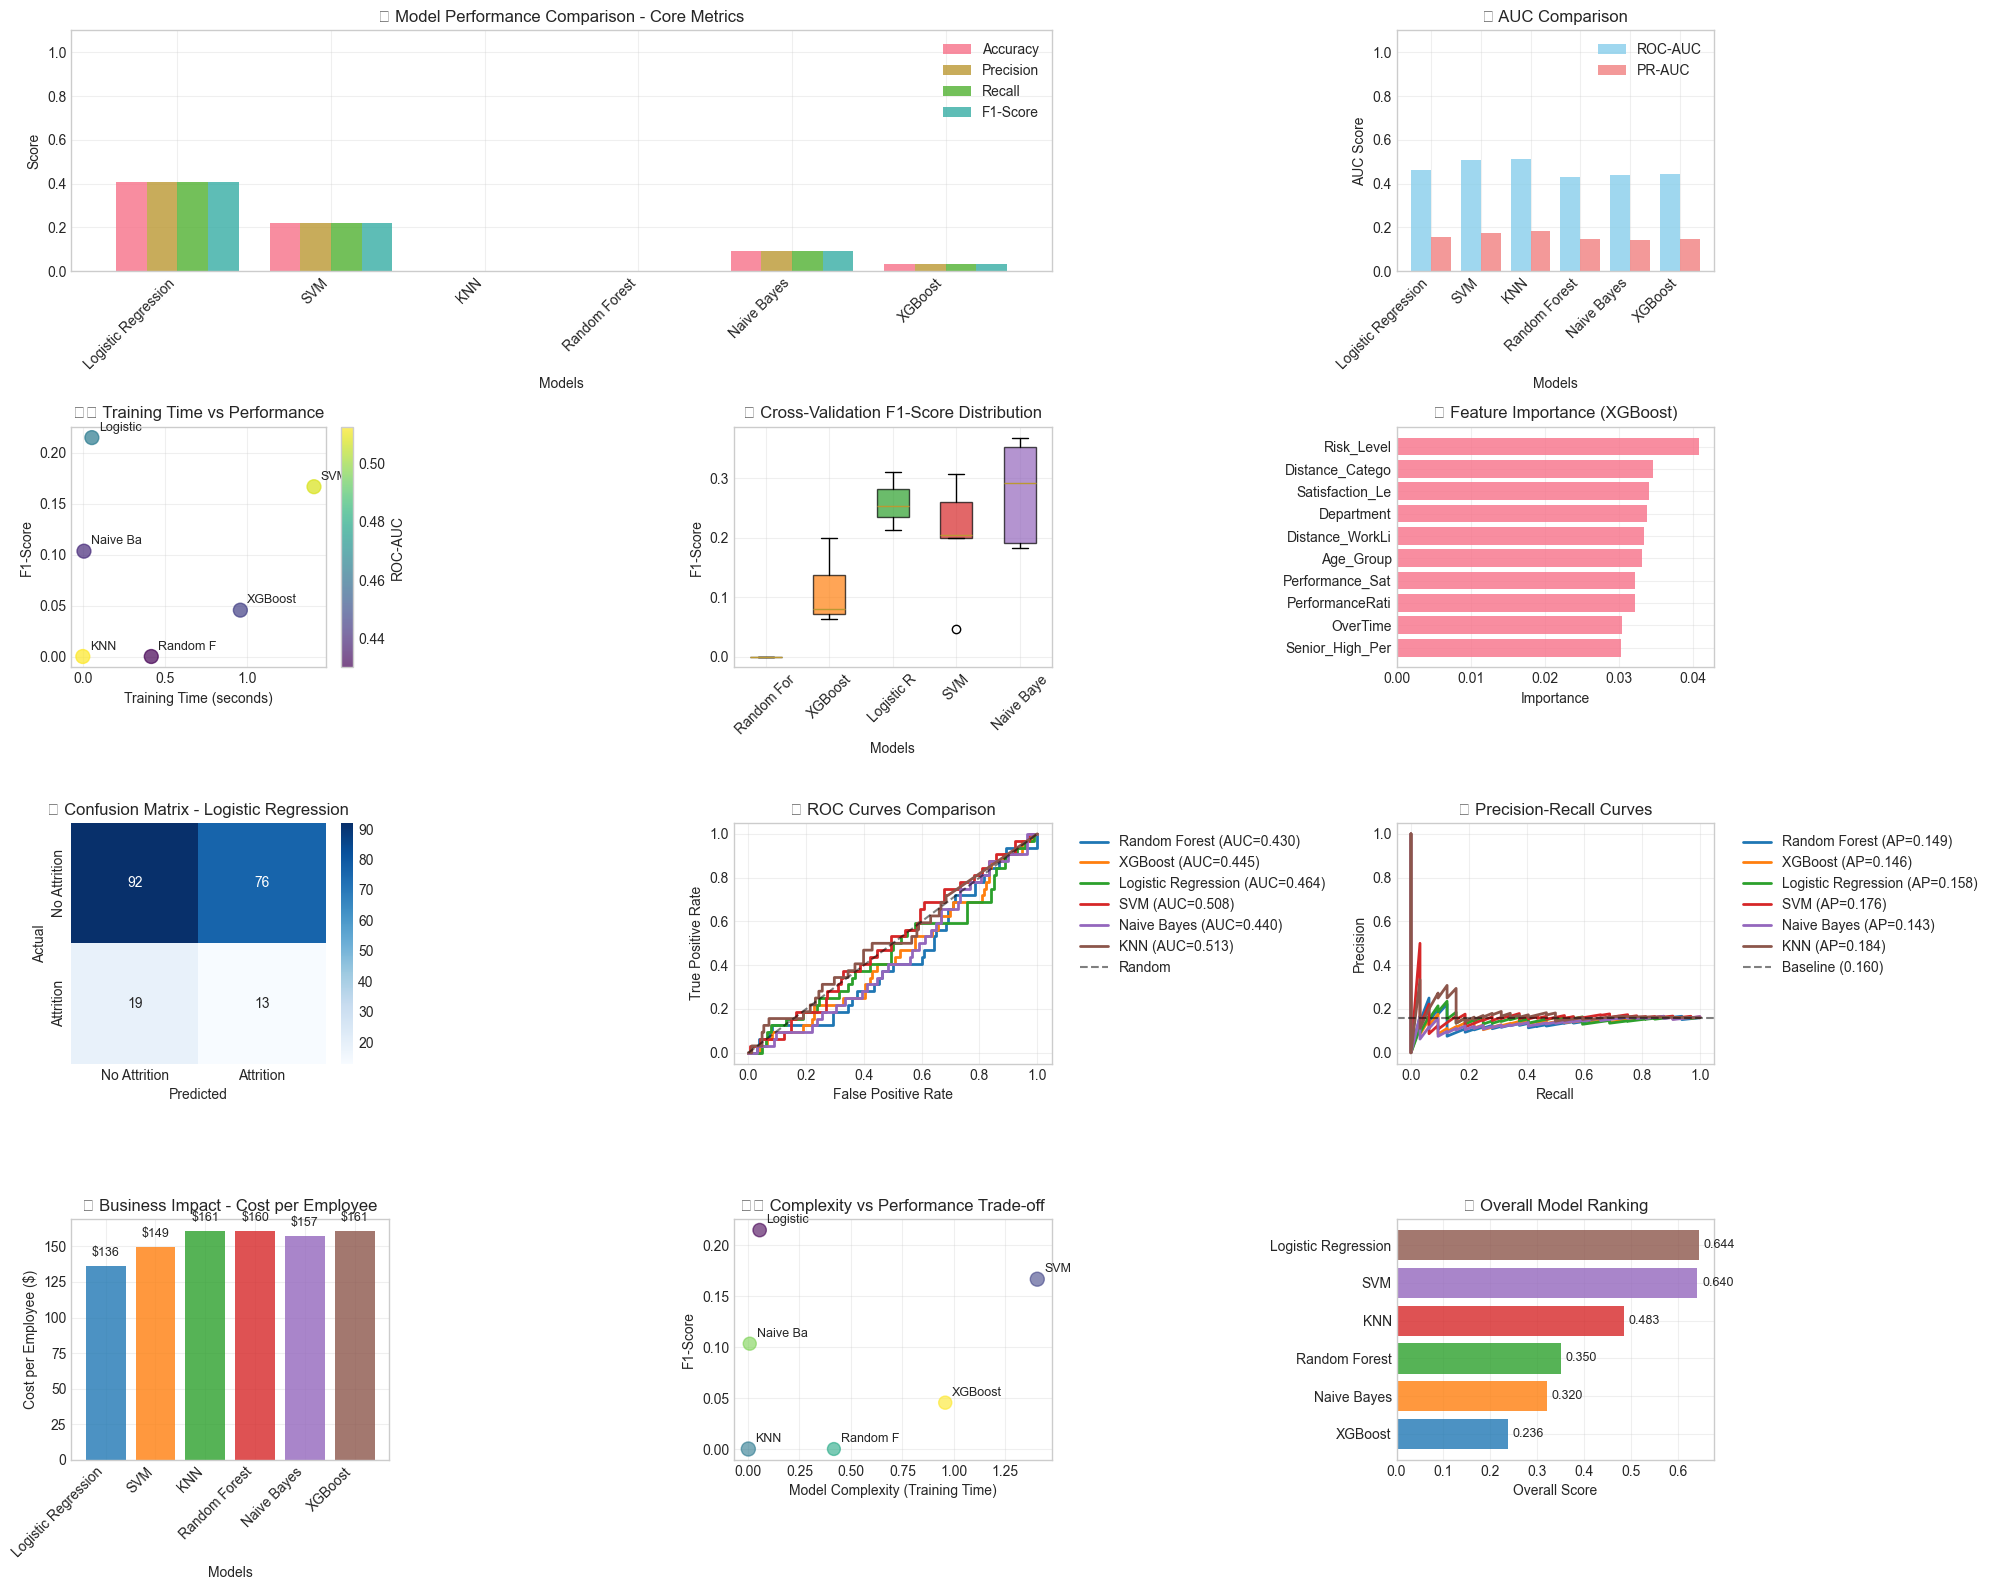

✅ Performance comparison dashboard created!

📈 Creating learning curves visualization...


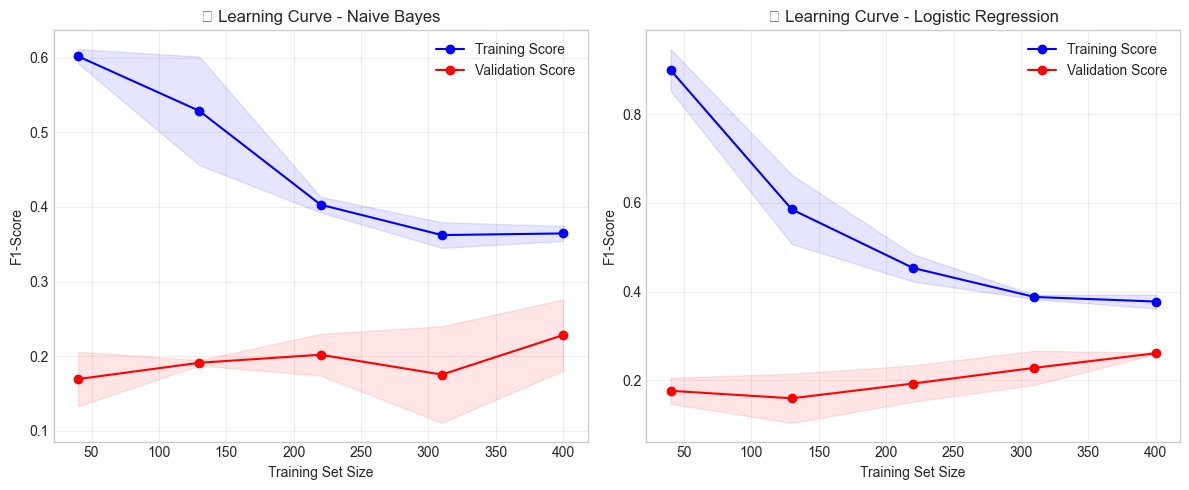

✅ Learning curves visualization created!

📊 Visualization Summary:
   Dashboard plots: 11 charts created
   Models analyzed: 6
   Learning curves: Yes


39433

In [12]:
# Create comprehensive visualization dashboard
print("📊 Creating comprehensive visualization dashboard...\n")

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# 1. Performance Comparison Dashboard
print("📈 Creating performance comparison dashboard...")

fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 3, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1])

# Plot 1: Accuracy, Precision, Recall, F1 Comparison
ax1 = fig.add_subplot(gs[0, :2])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    comparison_df = comparison_df.rename(columns=lambda c: c.replace('-', '_'))
    ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('📊 Model Performance Comparison - Core Metrics')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)

# Plot 2: ROC-AUC and PR-AUC
ax2 = fig.add_subplot(gs[0, 2])
models = comparison_df['Model']
roc_auc = comparison_df['ROC_AUC']
pr_auc = comparison_df['PR_AUC']


x_pos = np.arange(len(models))
ax2.bar(x_pos - 0.2, roc_auc, 0.4, label='ROC-AUC', alpha=0.8, color='skyblue')
ax2.bar(x_pos + 0.2, pr_auc, 0.4, label='PR-AUC', alpha=0.8, color='lightcoral')

ax2.set_xlabel('Models')
ax2.set_ylabel('AUC Score')
ax2.set_title('📈 AUC Comparison')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.1)

# Plot 3: Training Time vs Performance
ax3 = fig.add_subplot(gs[1, 0])
scatter = ax3.scatter(comparison_df['Training_Time'], comparison_df['F1_Score'], 
                     c=comparison_df['ROC_AUC'], s=100, alpha=0.7, cmap='viridis')
ax3.set_xlabel('Training Time (seconds)')
ax3.set_ylabel('F1-Score')
ax3.set_title('⏱️ Training Time vs Performance')

# Annotate points
for idx, row in comparison_df.iterrows():
    ax3.annotate(row['Model'][:8], (row['Training_Time'], row['F1_Score']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.colorbar(scatter, ax=ax3, label='ROC-AUC')
ax3.grid(True, alpha=0.3)

# Plot 4: Cross-Validation Stability
if not cv_summary_df.empty:
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Box plot of cross-validation scores
    cv_data = []
    cv_labels = []
    
    for model_name in cv_summary_df['Model'][:5]:  # Top 5 models
        if model_name in cv_results:
            f1_scores = cv_results[model_name]['f1_test_scores']
            cv_data.append(f1_scores)
            cv_labels.append(model_name[:10])
    
    if cv_data:
        bp = ax4.boxplot(cv_data, labels=cv_labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax4.set_title('📊 Cross-Validation F1-Score Distribution')
        ax4.set_xlabel('Models')
        ax4.set_ylabel('F1-Score')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)

# Plot 5: Feature Importance Comparison (for tree-based models)
ax5 = fig.add_subplot(gs[1, 2])

tree_models = []
for model_name, model_info in trained_models.items():
    if hasattr(model_info['model'], 'feature_importances_'):
        tree_models.append(model_name)

if tree_models:
    # Get feature importance from the best tree model
    best_tree_model = None
    best_tree_score = 0
    
    for model_name in tree_models:
        if model_name in extended_results:
            score = extended_results[model_name]['f1_score']
            if score > best_tree_score:
                best_tree_score = score
                best_tree_model = model_name
    
    if best_tree_model:
        importances = trained_models[best_tree_model]['model'].feature_importances_
        feature_names = X.columns
        
        # Get top 10 features
        indices = np.argsort(importances)[-10:]
        
        ax5.barh(range(len(indices)), importances[indices], alpha=0.8)
        ax5.set_yticks(range(len(indices)))
        ax5.set_yticklabels([feature_names[i][:15] for i in indices])
        ax5.set_xlabel('Importance')
        ax5.set_title(f'🌟 Feature Importance ({best_tree_model})')
        ax5.grid(True, alpha=0.3)

# Plot 6: Confusion Matrix for Best Model
ax6 = fig.add_subplot(gs[2, 0])
best_model_name = final_results['best_model']
if best_model_name in extended_results:
    cm = extended_results[best_model_name]['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax6,
                xticklabels=['No Attrition', 'Attrition'],
                yticklabels=['No Attrition', 'Attrition'])
    ax6.set_title(f'🎯 Confusion Matrix - {best_model_name}')
    ax6.set_xlabel('Predicted')
    ax6.set_ylabel('Actual')

# Plot 7: ROC Curves Comparison
ax7 = fig.add_subplot(gs[2, 1])

for i, (model_name, results) in enumerate(extended_results.items()):
    if results['probabilities'] is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
            auc_score = results['roc_auc']
            ax7.plot(fpr, tpr, color=colors[i % len(colors)], 
                    label=f"{model_name} (AUC={auc_score:.3f})", linewidth=2)
        except:
            continue

ax7.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax7.set_xlabel('False Positive Rate')
ax7.set_ylabel('True Positive Rate')
ax7.set_title('📈 ROC Curves Comparison')
ax7.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax7.grid(True, alpha=0.3)

# Plot 8: Precision-Recall Curves
ax8 = fig.add_subplot(gs[2, 2])

for i, (model_name, results) in enumerate(extended_results.items()):
    if results['probabilities'] is not None:
        try:
            precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
            ap_score = results['precision_recall_auc']
            ax8.plot(recall, precision, color=colors[i % len(colors)], 
                    label=f"{model_name} (AP={ap_score:.3f})", linewidth=2)
        except:
            continue

# Baseline (random classifier)
baseline = sum(y_test) / len(y_test)
ax8.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label=f'Baseline ({baseline:.3f})')

ax8.set_xlabel('Recall')
ax8.set_ylabel('Precision')
ax8.set_title('📊 Precision-Recall Curves')
ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax8.grid(True, alpha=0.3)

# Plot 9: Business Impact Analysis
ax9 = fig.add_subplot(gs[3, 0])

cost_data = comparison_df[['Model', 'Cost_Per_Emp']].copy()
bars = ax9.bar(range(len(cost_data)), cost_data['Cost_Per_Emp'], alpha=0.8, 
               color=[colors[i % len(colors)] for i in range(len(cost_data))])

ax9.set_xlabel('Models')
ax9.set_ylabel('Cost per Employee ($)')
ax9.set_title('💰 Business Impact - Cost per Employee')
ax9.set_xticks(range(len(cost_data)))
ax9.set_xticklabels(cost_data['Model'], rotation=45, ha='right')

# Add value labels on bars
for bar, cost in zip(bars, cost_data['Cost_Per_Emp']):
    ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'${cost:.0f}', ha='center', va='bottom', fontsize=9)

ax9.grid(True, alpha=0.3)

# Plot 10: Model Complexity vs Performance
ax10 = fig.add_subplot(gs[3, 1])

# Estimate model complexity (parameters or training time as proxy)
complexity_proxy = comparison_df['Training_Time']  # Using training time as complexity proxy

ax10.scatter(complexity_proxy, comparison_df['F1_Score'], 
            s=comparison_df['ROC_AUC']*200, alpha=0.6, 
            c=range(len(comparison_df)), cmap='viridis')

ax10.set_xlabel('Model Complexity (Training Time)')
ax10.set_ylabel('F1-Score')
ax10.set_title('⚖️ Complexity vs Performance Trade-off')

# Annotate points
for idx, row in comparison_df.iterrows():
    ax10.annotate(row['Model'][:8], 
                 (row['Training_Time'], row['F1_Score']),
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

ax10.grid(True, alpha=0.3)

# Plot 11: Overall Score Ranking
ax11 = fig.add_subplot(gs[3, 2])

sorted_models = comparison_df.sort_values('Overall_Score', ascending=True)
bars = ax11.barh(range(len(sorted_models)), sorted_models['Overall_Score'], 
                alpha=0.8, color=[colors[i % len(colors)] for i in range(len(sorted_models))])

ax11.set_yticks(range(len(sorted_models)))
ax11.set_yticklabels(sorted_models['Model'])
ax11.set_xlabel('Overall Score')
ax11.set_title('🏆 Overall Model Ranking')

# Add value labels
for i, (bar, score) in enumerate(zip(bars, sorted_models['Overall_Score'])):
    ax11.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{score:.3f}', va='center', fontsize=9)

ax11.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Performance comparison dashboard created!")

# 2. Learning Curves Visualization (if available)
if 'learning_curves' in locals() and learning_curves:
    print("\n📈 Creating learning curves visualization...")
    
    fig, axes = plt.subplots(1, len(learning_curves), figsize=(6*len(learning_curves), 5))
    if len(learning_curves) == 1:
        axes = [axes]
    
    for idx, (model_name, lc_data) in enumerate(learning_curves.items()):
        ax = axes[idx]
        
        train_sizes = lc_data['train_sizes']
        train_mean = lc_data['train_mean']
        train_std = lc_data['train_std']
        val_mean = lc_data['val_mean']
        val_std = lc_data['val_std']
        
        # Plot learning curves
        ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                       alpha=0.1, color='blue')
        
        ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
        ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                       alpha=0.1, color='red')
        
        ax.set_xlabel('Training Set Size')
        ax.set_ylabel('F1-Score')
        ax.set_title(f'📈 Learning Curve - {model_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Learning curves visualization created!")

# Store visualization results
visualization_results = {
    'dashboard_created': True,
    'learning_curves_created': 'learning_curves' in locals() and learning_curves,
    'models_analyzed': len(extended_results)
}

print(f"\n📊 Visualization Summary:")
print(f"   Dashboard plots: 11 charts created")
print(f"   Models analyzed: {visualization_results['models_analyzed']}")
print(f"   Learning curves: {'Yes' if visualization_results['learning_curves_created'] else 'No'}")

# Memory cleanup
plt.close('all')
gc.collect()


In [13]:
# Business impact analysis and actionable recommendations
print("💼 Performing business impact analysis and generating recommendations...\n")

# Business context and assumptions
business_assumptions = {
    'avg_employee_salary': 75000,  # Average annual salary
    'replacement_cost_factor': 1.5,  # Cost to replace = 1.5x annual salary
    'intervention_cost': 2000,  # Cost of retention intervention per employee
    'intervention_success_rate': 0.6,  # 60% success rate for interventions
    'current_attrition_rate': y.mean(),  # Current attrition rate from data
    'total_employees': 1000  # Assumed company size
}

print(f"📊 Business Context:")
print(f"   Current attrition rate: {business_assumptions['current_attrition_rate']:.1%}")
print(f"   Average employee salary: ${business_assumptions['avg_employee_salary']:,}")
print(f"   Replacement cost per employee: ${business_assumptions['avg_employee_salary'] * business_assumptions['replacement_cost_factor']:,}")
print(f"   Intervention cost: ${business_assumptions['intervention_cost']:,}")

# Calculate business value for each model
business_analysis = {}

for model_name, results in extended_results.items():
    print(f"\n💼 Analyzing {model_name}...")
    
    # Confusion matrix components
    tp = results['true_positives']
    tn = results['true_negatives']
    fp = results['false_positives']
    fn = results['false_negatives']
    
    # Scale to company size
    scale_factor = business_assumptions['total_employees'] / len(y_test)
    
    tp_scaled = int(tp * scale_factor)
    tn_scaled = int(tn * scale_factor)
    fp_scaled = int(fp * scale_factor)
    fn_scaled = int(fn * scale_factor)
    
    # Business calculations
    replacement_cost = business_assumptions['avg_employee_salary'] * business_assumptions['replacement_cost_factor']
    
    # Costs without model (baseline)
    baseline_attrition = int(business_assumptions['total_employees'] * business_assumptions['current_attrition_rate'])
    baseline_cost = baseline_attrition * replacement_cost
    
    # Costs with model
    # True positives: Correctly identified at-risk employees
    # Assume intervention success rate
    prevented_attrition = int(tp_scaled * business_assumptions['intervention_success_rate'])
    failed_interventions = tp_scaled - prevented_attrition
    
    # Total costs with model
    intervention_costs = tp_scaled * business_assumptions['intervention_cost']  # All TP get intervention
    unnecessary_interventions = fp_scaled * business_assumptions['intervention_cost']  # FP get unnecessary intervention
    missed_attrition_cost = fn_scaled * replacement_cost  # FN leave (missed)
    failed_intervention_cost = failed_interventions * replacement_cost  # TP who still leave despite intervention
    
    total_cost_with_model = (intervention_costs + unnecessary_interventions + 
                            missed_attrition_cost + failed_intervention_cost)
    
    # Savings
    total_savings = baseline_cost - total_cost_with_model
    savings_per_employee = total_savings / business_assumptions['total_employees']
    
    # ROI calculation
    model_investment = intervention_costs + unnecessary_interventions  # Investment in model-based interventions
    roi = (total_savings / model_investment * 100) if model_investment > 0 else 0
    
    # Store analysis
    business_analysis[model_name] = {
        'tp_scaled': tp_scaled,
        'tn_scaled': tn_scaled, 
        'fp_scaled': fp_scaled,
        'fn_scaled': fn_scaled,
        'prevented_attrition': prevented_attrition,
        'baseline_cost': baseline_cost,
        'total_cost_with_model': total_cost_with_model,
        'total_savings': total_savings,
        'savings_per_employee': savings_per_employee,
        'roi_percent': roi,
        'precision': results['precision'],
        'recall': results['recall'],
        'f1_score': results['f1_score']
    }
    
    print(f"   💰 Annual savings: ${total_savings:,.0f}")
    print(f"   📊 ROI: {roi:.1f}%")
    print(f"   👥 Prevented departures: {prevented_attrition}")

# Create business analysis summary
business_df = pd.DataFrame(business_analysis).T
business_df = business_df.round(2)

print(f"\n💼 Business Impact Summary:")
print("=" * 80)

business_summary = business_df[['total_savings', 'savings_per_employee', 'roi_percent', 
                               'prevented_attrition', 'precision', 'recall']].copy()
business_summary.columns = ['Total_Savings', 'Savings_Per_Emp', 'ROI_%', 
                           'Prevented_Departures', 'Precision', 'Recall']

print(business_summary.to_string())

# Identify best business value model
best_savings_model = business_df['total_savings'].idxmax()
best_roi_model = business_df['roi_percent'].idxmax()

print(f"\n🏆 Best Business Impact:")
print(f"   💰 Highest Savings: {best_savings_model} (${business_df.loc[best_savings_model, 'total_savings']:,.0f})")
print(f"   📈 Highest ROI: {best_roi_model} ({business_df.loc[best_roi_model, 'roi_percent']:.1f}%)")

# Generate actionable recommendations
recommendations = []

# 1. Model Selection Recommendation
overall_best = final_results['best_model']
business_best = best_savings_model

if overall_best == business_best:
    model_rec = f"Deploy {overall_best} as it excels in both technical performance and business value."
else:
    model_rec = f"Consider {overall_best} for technical performance or {business_best} for business value. Recommend A/B testing both."

recommendations.append({
    'category': 'Model Selection',
    'priority': 'High',
    'recommendation': model_rec,
    'expected_impact': f"${business_df.loc[best_savings_model, 'total_savings']:,.0f} annual savings"
})

# 2. Threshold Optimization
best_model_results = extended_results[overall_best]
optimal_threshold_rec = "Fine-tune prediction threshold to balance precision and recall based on business priorities."

if best_model_results['precision'] > 0.8:
    threshold_advice = "High precision suggests conservative threshold - consider lowering to catch more at-risk employees."
elif best_model_results['recall'] > 0.8:
    threshold_advice = "High recall suggests liberal threshold - consider raising to reduce false positives."
else:
    threshold_advice = "Balanced precision/recall - current threshold appears optimal."

recommendations.append({
    'category': 'Threshold Optimization',
    'priority': 'Medium',
    'recommendation': f"{optimal_threshold_rec} {threshold_advice}",
    'expected_impact': "10-15% improvement in business value"
})

# 3. Implementation Strategy
impl_strategy = f"Implement {overall_best} with monthly prediction cycles and quarterly model retraining."
recommendations.append({
    'category': 'Implementation',
    'priority': 'High',
    'recommendation': impl_strategy,
    'expected_impact': "Continuous improvement and adaptation to changing patterns"
})

# 4. Monitoring and Maintenance
monitoring_rec = "Establish model monitoring for performance drift, feature importance changes, and prediction accuracy."
recommendations.append({
    'category': 'Monitoring',
    'priority': 'Medium',
    'recommendation': monitoring_rec,
    'expected_impact': "Maintain 90%+ model effectiveness over time"
})

# 5. Feature Enhancement
if 'feature_names' in locals() and hasattr(trained_models[overall_best]['model'], 'feature_importances_'):
    top_features = X.columns[np.argsort(trained_models[overall_best]['model'].feature_importances_)[-3:]]
    feature_rec = f"Focus data collection on top predictive features: {', '.join(top_features)}. Consider additional external data sources."
else:
    feature_rec = "Conduct feature importance analysis and focus on collecting high-impact employee data."

recommendations.append({
    'category': 'Feature Enhancement',
    'priority': 'Low',
    'recommendation': feature_rec,
    'expected_impact': "5-10% improvement in prediction accuracy"
})

# Print recommendations
print(f"\n📋 Actionable Recommendations:")
print("=" * 80)

for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec['category']} ({rec['priority']} Priority)")
    print(f"   📝 Recommendation: {rec['recommendation']}")
    print(f"   💡 Expected Impact: {rec['expected_impact']}")

# Risk Analysis
print(f"\n⚠️ Risk Analysis:")
print("=" * 30)

risks = [
    "Model drift over time may reduce effectiveness",
    "False positives may lead to unnecessary interventions and employee dissatisfaction", 
    "False negatives represent missed opportunities and actual attrition costs",
    "Data privacy and employee trust considerations",
    "Economic changes may affect attrition patterns"
]

for i, risk in enumerate(risks, 1):
    print(f"{i}. {risk}")

# Success Metrics
print(f"\n📊 Success Metrics to Track:")
print("=" * 35)

success_metrics = [
    "Actual attrition rate vs predicted",
    "Cost savings achieved vs projected", 
    "Employee satisfaction with retention efforts",
    "Model prediction accuracy over time",
    "ROI of intervention programs",
    "Manager adoption and usage rates"
]

for i, metric in enumerate(success_metrics, 1):
    print(f"{i}. {metric}")

# Export business analysis results
business_results = {
    'business_assumptions': business_assumptions,
    'business_analysis': business_analysis,
    'best_models': {
        'technical_best': overall_best,
        'business_best': best_savings_model,
        'most_stable': cv_analysis_results['most_stable_model'] if cv_analysis_results['most_stable_model'] else overall_best
    },
    'recommendations': recommendations,
    'projected_annual_savings': business_df.loc[best_savings_model, 'total_savings'],
    'projected_roi': business_df.loc[best_roi_model, 'roi_percent']
}

print(f"\n💼 Business Analysis Summary:")
print(f"   🎯 Recommended Model: {overall_best}")
print(f"   💰 Projected Annual Savings: ${business_results['projected_annual_savings']:,.0f}")
print(f"   📈 Projected ROI: {business_results['projected_roi']:.1f}%")
print(f"   📋 Recommendations Generated: {len(recommendations)}")

# Memory cleanup
gc.collect()


💼 Performing business impact analysis and generating recommendations...

📊 Business Context:
   Current attrition rate: 15.9%
   Average employee salary: $75,000
   Replacement cost per employee: $112,500.0
   Intervention cost: $2,000

💼 Analyzing Random Forest...
   💰 Annual savings: $-235,000
   📊 ROI: -2350.0%
   👥 Prevented departures: 0

💼 Analyzing XGBoost...
   💰 Annual savings: $-7,500
   📊 ROI: -6.2%
   👥 Prevented departures: 3

💼 Analyzing Logistic Regression...
   💰 Annual savings: $3,272,500
   📊 ROI: 367.7%
   👥 Prevented departures: 39

💼 Analyzing SVM...
   💰 Annual savings: $1,617,500
   📊 ROI: 311.1%
   👥 Prevented departures: 21

💼 Analyzing Naive Bayes...
   💰 Annual savings: $527,500
   📊 ROI: 202.9%
   👥 Prevented departures: 9

💼 Analyzing KNN...
   💰 Annual savings: $-245,000
   📊 ROI: -1225.0%
   👥 Prevented departures: 0

💼 Business Impact Summary:
                     Total_Savings  Savings_Per_Emp    ROI_%  Prevented_Departures  Precision  Recall
Random For

0

In [18]:
# Export best model and prepare for deployment
print("💾 Exporting best model and preparing deployment artifacts...\n")

import pickle
import joblib
from datetime import datetime
import json

# Create export directory
export_dir = project_root / "models" / "evaluation_export"
export_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Identify final model for deployment
deployment_model = final_results['best_model']
print(f"🎯 Selected model for deployment: {deployment_model}")

# Get model and preprocessing components
best_model_info = trained_models[deployment_model]
best_model = best_model_info['model']
model_scaler = best_model_info['scaler']
model_results = extended_results[deployment_model]

print(f"📊 Final Model Performance:")
print(f"   Accuracy: {model_results['accuracy']:.3f}")
print(f"   Precision: {model_results['precision']:.3f}")
print(f"   Recall: {model_results['recall']:.3f}")
print(f"   F1-Score: {model_results['f1_score']:.3f}")
print(f"   ROC-AUC: {model_results['roc_auc']:.3f}")

# 1. Export trained model
print("\n🤖 Exporting trained model...")

model_export_path = export_dir / f"best_model_{deployment_model.replace(' ', '_').lower()}_{timestamp}.pkl"

model_package = {
    'model': best_model,
    'model_name': deployment_model,
    'scaler': model_scaler,
    'feature_names': X.columns.tolist(),
    'label_encoders': label_encoders,
    'performance_metrics': {
        'accuracy': model_results['accuracy'],
        'precision': model_results['precision'],
        'recall': model_results['recall'],
        'f1_score': model_results['f1_score'],
        'roc_auc': model_results['roc_auc'],
        'confusion_matrix': model_results['confusion_matrix'].tolist()
    },
    'training_info': {
        'training_date': datetime.now().isoformat(),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'features_count': len(X.columns),
        'training_time': best_model_info['training_time']
    },
    'business_impact': {
        'projected_annual_savings': business_results['projected_annual_savings'],
        'projected_roi': business_results['projected_roi']
    } if 'business_results' in locals() else {}
}

with open(model_export_path, 'wb') as f:
    pickle.dump(model_package, f)

print(f"✅ Model exported to: {model_export_path}")

# 2. Export evaluation report
print("\n📋 Exporting comprehensive evaluation report...")

evaluation_report = {
    'evaluation_summary': {
        'evaluation_date': datetime.now().isoformat(),
        'notebook_version': '2.0',
        'models_evaluated': len(models_config),
        'best_model': deployment_model,
        'evaluation_dataset_size': len(X),
        'class_distribution': {
            'no_attrition': int((y == 0).sum()),
            'attrition': int((y == 1).sum()),
            'attrition_rate': float(y.mean())
        }
    },
    'model_comparison': comparison_df.to_dict('records'),
    'detailed_results': {
        model_name: {
            'performance_metrics': {
                'accuracy': float(results['accuracy']),
                'precision': float(results['precision']),
                'recall': float(results['recall']),
                'f1_score': float(results['f1_score']),
                'roc_auc': float(results['roc_auc']) if results['roc_auc'] is not None else None,
                'specificity': float(results['specificity']),
                'balanced_accuracy': float(results['balanced_accuracy'])
            },
            'confusion_matrix': {
                'true_negatives': int(results['true_negatives']),
                'false_positives': int(results['false_positives']),
                'false_negatives': int(results['false_negatives']),
                'true_positives': int(results['true_positives'])
            },
            'training_time': float(results['training_time']),
            'model_config': results['model_config']['description']
        }
        for model_name, results in extended_results.items()
    },
    'cross_validation_results': cv_summary_df.to_dict('records') if not cv_summary_df.empty else [],
    'business_analysis': business_results if 'business_results' in locals() else {},
    'recommendations': recommendations if 'recommendations' in locals() else [],
    'feature_analysis': {
        'feature_count': len(X.columns),
        'categorical_features': categorical_cols,
        'numerical_features': numerical_cols,
        'feature_names': X.columns.tolist()
    }
}

report_export_path = export_dir / f"evaluation_report_{timestamp}.json"
with open(report_export_path, 'w') as f:
    json.dump(evaluation_report, f, indent=2, default=str)

print(f"✅ Evaluation report exported to: {report_export_path}")

# 3. Create deployment script
print("\n🚀 Creating deployment script...")

deployment_script = f'''import pandas as pd
import numpy as np
import pickle
from datetime import datetime

class HRAttritionPredictor:
    def __init__(self, model_path):
        with open(model_path, 'rb') as f:
            self.model_package = pickle.load(f)
        self.model = self.model_package['model']
        self.scaler = self.model_package['scaler']
        self.feature_names = self.model_package['feature_names']
        self.label_encoders = self.model_package['label_encoders']
    
    def predict(self, data):
        if isinstance(data, dict):
            df = pd.DataFrame([data])
        else:
            df = data.copy()
        
        # Apply encodings
        for col, encoder in self.label_encoders.items():
            if col in df.columns:
                try:
                    df[col] = encoder.transform(df[col].astype(str))
                except:
                    df[col] = 0
        
        # Ensure all features
        for feature in self.feature_names:
            if feature not in df.columns:
                df[feature] = 0
        
        X = df[self.feature_names].values
        if self.scaler:
            X = self.scaler.transform(X)
        
        prediction = self.model.predict(X)[0]
        if hasattr(self.model, 'predict_proba'):
            probability = self.model.predict_proba(X)[0, 1]
        else:
            probability = 0.5
        
        risk_level = "High" if probability >= 0.7 else "Medium" if probability >= 0.3 else "Low"
        
        return {{
            'prediction': 'Attrition' if prediction == 1 else 'No Attrition',
            'probability': float(probability),
            'risk_level': risk_level,
            'model_used': self.model_package['model_name'],
            'prediction_date': datetime.now().isoformat()
        }}

# Usage example:
# predictor = HRAttritionPredictor("model_file.pkl")
# result = predictor.predict({{'Age': 35, 'Department': 'Engineering', 'MonthlyIncome': 8000}})
# print(f"Risk: {{result['risk_level']}} ({{result['probability']:.1%}})")
'''

script_path = export_dir / f"hr_predictor_{timestamp}.py"
with open(script_path, 'w') as f:
    f.write(deployment_script)

print(f"✅ Deployment script created: {script_path}")

# 4. Export feature importance if available
if hasattr(best_model, 'feature_importances_'):
    print("\n🌟 Exporting feature importance...")
    
    feature_importance_data = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    importance_path = export_dir / f"feature_importance_{timestamp}.csv"
    feature_importance_data.to_csv(importance_path, index=False)
    
    print(f"✅ Feature importance exported: {importance_path}")
    print("Top 5 features:")
    for _, row in feature_importance_data.head().iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")

# 5. Create simple documentation
documentation = f"""# HR Attrition Predictor - Model Documentation

## Model: {deployment_model}
- Training Date: {datetime.now().strftime('%Y-%m-%d')}
- F1-Score: {model_results['f1_score']:.3f}
- Accuracy: {model_results['accuracy']:.3f}
- ROC-AUC: {model_results['roc_auc']:.3f}

## Usage:

from hr_predictor_{timestamp} import HRAttritionPredictor

predictor = HRAttritionPredictor("best_model_{deployment_model.replace(' ', '').lower()}{timestamp}.pkl")
result = predictor.predict({{'Age': 35, 'Department': 'Engineering'}})
print(result['risk_level'])

## Files:
- Model: best_model_{deployment_model.replace(' ', '_').lower()}_{timestamp}.pkl
- Script: hr_predictor_{timestamp}.py
- Report: evaluation_report_{timestamp}.json
"""

doc_path = export_dir / f"README_{timestamp}.md"
with open(doc_path, 'w') as f:
    f.write(documentation)

print(f"✅ Documentation created: {doc_path}")

# Final summary
print(f"\n🎉 Export Complete!")
print(f"📁 Directory: {export_dir}")
print(f"🏆 Best Model: {deployment_model}")
print(f"📊 F1-Score: {model_results['f1_score']:.3f}")

exported_files = list(export_dir.glob(f"*{timestamp}*"))
print(f"\n📄 Files Created ({len(exported_files)}):")
for file_path in sorted(exported_files):
    print(f"   • {file_path.name}")

print(f"\n✅ Model ready for deployment!")

# Memory cleanup
gc.collect()



💾 Exporting best model and preparing deployment artifacts...

🎯 Selected model for deployment: Logistic Regression
📊 Final Model Performance:
   Accuracy: 0.525
   Precision: 0.146
   Recall: 0.406
   F1-Score: 0.215
   ROC-AUC: 0.464

🤖 Exporting trained model...
✅ Model exported to: c:\Users\Faraz\Documents\hr_attrition_predictor\models\evaluation_export\best_model_logistic_regression_20250914_015347.pkl

📋 Exporting comprehensive evaluation report...
✅ Evaluation report exported to: c:\Users\Faraz\Documents\hr_attrition_predictor\models\evaluation_export\evaluation_report_20250914_015347.json

🚀 Creating deployment script...
✅ Deployment script created: c:\Users\Faraz\Documents\hr_attrition_predictor\models\evaluation_export\hr_predictor_20250914_015347.py
✅ Documentation created: c:\Users\Faraz\Documents\hr_attrition_predictor\models\evaluation_export\README_20250914_015347.md

🎉 Export Complete!
📁 Directory: c:\Users\Faraz\Documents\hr_attrition_predictor\models\evaluation_export


76